In [5]:
%config InlineBackend.figure_format = "svg"

# Data visualization imports
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing imports
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
import pandas as pd
import numpy as np

# Progress bar
from tqdm import tqdm

## Import data

In [6]:
df = pd.read_csv("my_data/depth_pcd.csv")
df

,x,y,z,nx,ny,nz,cluster,tread,depth
0,-0.002940,-0.04294,0.290140,-0.326147,0.045403,0.944228,0,True,0.001391
1,0.138690,-0.05471,0.397650,0.826433,-0.048764,-0.560919,6,False,0.008265
2,0.146500,-0.00176,0.394075,0.804035,-0.001458,-0.594581,1,True,0.001249
3,0.044395,-0.00903,0.309410,-0.437302,0.408187,0.801343,1,True,0.000984
4,0.056847,-0.12176,0.330673,-0.613172,0.360063,0.703118,2,True,0.009674
...,...,...,...,...,...,...,...,...,...
43914,-0.108820,0.03000,0.269220,-0.033776,-0.142515,0.989216,4,True,0.002004
43915,-0.106470,0.03000,0.269310,-0.047981,-0.125475,0.990936,4,True,0.002047
43916,-0.128820,0.03000,0.269370,0.005268,-0.056899,0.998366,4,True,0.001881
43917,-0.127650,0.03000,0.269360,0.000712,-0.063930,0.997954,4,True,0.001920


## Plot depth histograms

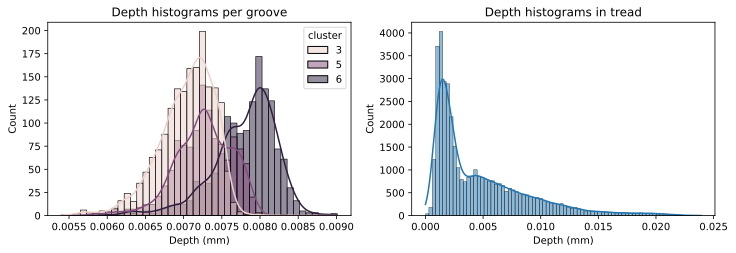

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3.5))

# Plot the data
axs[0].set_title("Depth histograms per groove")
sns.histplot(data=df.query("not tread"), x="depth", hue="cluster", kde=True, ax=axs[0])
axs[0].set_xlabel("Depth (mm)")
axs[1].set_title("Depth histograms in tread")
sns.histplot(data=df.query("tread"), x="depth", kde=True, ax=axs[1])
axs[1].set_xlabel("Depth (mm)")
plt.show()

From this plot, we can see that both the tread and the groove data have peaks at different depths. These peaks likely correspond to the tread and groove bottom depths, where the point cloud is more densely populated.

With this plot, we can clearly see that the peaks of the groove distributions represent the depth of the bottom of the grooves. They are close to normally distributed, but somewhat left skewed.

To calculate the depth of the groove bottoms, we need to subtract the groove depth by the tread depth.
We will do this in the following manner:
- Approximate histogram distributions for tread and grooves using KDE
- Calculate multiple estimates of their peak difference to get the peak difference distribution 
- Use the mean of the distribution as the predicted value of the difference
- Calculate prediction interval according to a certain significance level from the distribution

## Part 1: KDE histogram fitting and approximating difference distribution per groove

In [8]:
# Define number of samples for the difference distribution
random_state = 42
n_samples = 1000
peak_samples = 250

# Initialize dictionary of difference samples
diff_df = {"groove": [], "lower": [], "upper": []}

# Get groove data, tread data and tread kde
bottom_df = df.query("not tread")
tread_df = df.query("tread")

# Iterate each groove
for g in bottom_df.cluster.unique():
    
    # Filter groove bottom data
    groove_df = bottom_df.query(f"cluster == {g}")
    
    # Calculate multiple estimates for the peak difference
    tsamples, gsamples = [], []
    for _ in tqdm(range(peak_samples), desc="Finding peaks", total=peak_samples):
        
        # Sample and estimate kde from dataframes
        xt = tread_df["depth"].sample(n_samples, random_state=random_state).values
        xg = groove_df["depth"].sample(n_samples, random_state=random_state).values
        tkde, gkde = gaussian_kde(xt), gaussian_kde(xg)
        yt, yg = tkde(xt), gkde(xg)
        
        # Find peaks
        tpeak, gpeak = np.argmax(yt), np.argmax(yg)
        tpeak, gpeak = xt[tpeak], xg[gpeak]
        
        # Add to peak list
        tsamples.append(tpeak)
        gsamples.append(gpeak)
    
    # Add samples to dictionary
    grooves = g * np.ones(shape=peak_samples, dtype="int64")
    diff_df["groove"].append(grooves)
    diff_df["lower"].append(np.array(tsamples))
    diff_df["upper"].append(np.array(gsamples))
    
# Concatenate all samples
diff_df["groove"] = np.concatenate(diff_df["groove"])
diff_df["lower"] = np.concatenate(diff_df["lower"])
diff_df["upper"] = np.concatenate(diff_df["upper"])
    
# Turn dictionary into dataframe
diff_df = pd.DataFrame(diff_df)
diff_df

Finding peaks: 100%|█████████████████████████████████████████████████████████████████| 250/250 [00:40<00:00,  6.17it/s]


,groove,lower,upper
0,6,0.001713,0.007997
1,6,0.001725,0.008009
2,6,0.001762,0.007993
3,6,0.001690,0.007987
4,6,0.001783,0.007997
...,...,...,...
745,5,0.001786,0.007266
746,5,0.001791,0.007275
747,5,0.001622,0.007259
748,5,0.001700,0.007269


Now let's plot the distribution of the depth difference for each groove:

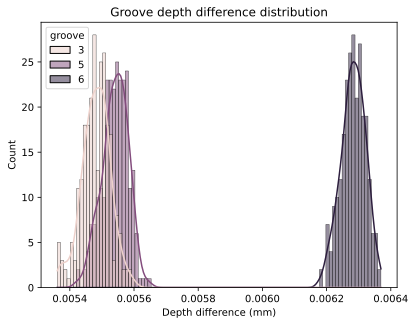

In [9]:
# Add difference to dataframe
plot_df = diff_df
plot_df["diff"] = diff_df["upper"] - diff_df["lower"]
plot_df = plot_df.drop(columns=["upper", "lower"])

# Plot the difference distributions
plt.title("Groove depth difference distribution")
sns.histplot(data=plot_df, x="diff", bins=100, hue="groove", kde=True)
plt.xlabel("Depth difference (mm)")
plt.show()

## Mean and prediction interval estimation

Now we can estimate the groove depth as the mean of the distribution.

In [10]:
# Get the mean per goove
mean_df = plot_df.rename(columns={"diff": "mean"}).groupby("groove", as_index=False).mean()
mean_df

,groove,mean
0,3,0.005481
1,5,0.005541
2,6,0.006283


Given a significance $\alpha$, we define the prediction interval as the quantiles $\alpha/2$ and $1 - \alpha/2$:

In [11]:
# Define significance
significance = 0.05

# Define interval dataframe
interval_df = plot_df.rename(columns={"diff": "lower"})
interval_df["upper"] = interval_df["lower"]

# Get the quantiles
interval_df = interval_df.groupby("groove", as_index=False).agg({
    "lower": lambda x: np.quantile(x, significance/2),
    "upper": lambda x: np.quantile(x, 1-significance/2)
})
interval_df

,groove,lower,upper
0,3,0.005378,0.005563
1,5,0.005459,0.005610
2,6,0.006205,0.006354


Now let's plot these regions along with their distributions:

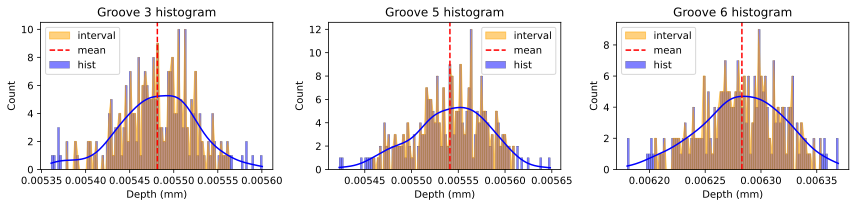

In [12]:
# Get grooves
grooves = mean_df.groove.unique()

# Define axis and figure
fig, axs = plt.subplots(1, grooves.shape[0], figsize=(12, 3))

# Iterate grooves
for ax, g in zip(axs, grooves):
    
    # Calculate histogram of data
    hist, bins = np.histogram(plot_df.query(f"groove == {g}")["diff"], bins=100)
    
    # Calculate x and y data for fill between plot
    x_min = interval_df.query(f"groove == {g}").lower
    x_max = interval_df.query(f"groove == {g}").upper
    x = np.linspace(x_min, x_max, 100).reshape(-1)
    y_min = np.zeros(x.shape[0])
    y_max = hist[np.digitize(x, bins)-1]
    
    # Get mean
    x_mean = mean_df.loc[mean_df["groove"] == g, "mean"].values[0]
    
    # Make the plot
    ax.set_title(f"Groove {g} histogram")
    sns.histplot(data=plot_df.query(f"groove == {g}"), x="diff", label="hist", kde=True, color="blue", ax=ax, bins=100)
    ax.fill_between(x, y_min, y_max, label="interval", color="orange", alpha=0.5)
    ax.axvline(x_mean, label="mean", color="red", linestyle="--")
    ax.set_xlabel("Depth (mm)")
    ax.legend()
    
plt.tight_layout()
plt.show()    

Therefore, from this analysis, we can verify that the depth of the grooves are very likely to be above $3$ mm, which implies that its performance has likely not fallen off.

## Plot groove points inside selected range

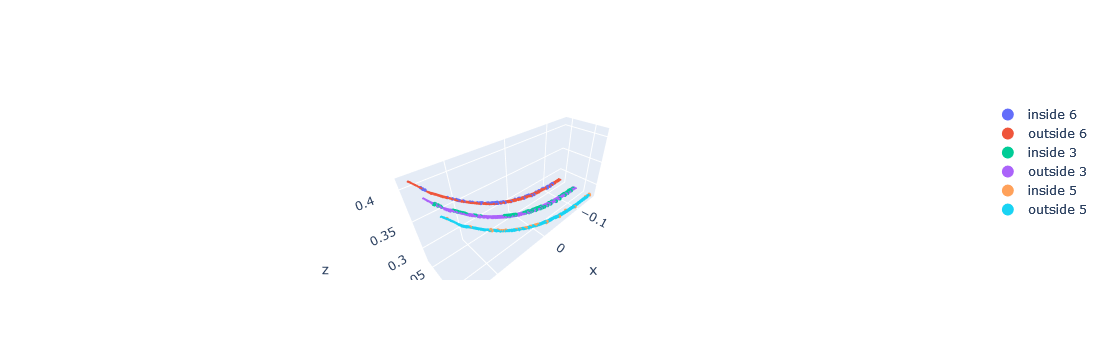

In [17]:
# Iterate every groove
data = []
for g in diff_df.groove.unique():
    # Filter data for that groove
    groove_df = diff_df.query(f"groove == {g}")
    
    ## Get mean and std of groove depths
    mean, std = groove_df["upper"].mean(), groove_df["upper"].std()
    
    # Get data points of groove inside that depth
    inside_df = df.query(f"cluster == {g} and depth <= {mean + 2*std} and depth >= {mean - 2*std}")
    outside_df = df.query(f"cluster == {g} and (depth > {mean + 2*std} or depth < {mean - 2*std})")
    
    # Append datapoints to data list
    data.append(
        go.Scatter3d(
            x=inside_df.x, y=inside_df.y, z=inside_df.z, 
            mode="markers", marker=dict(size=2, color=g), name=f"inside {g}"
        )
    )
    data.append(
        go.Scatter3d(
            x=outside_df.x, y=outside_df.y, z=outside_df.z, 
            mode="markers", marker=dict(size=1, color=-g), name=f"outside {g}"
        )
    )
    
# Plot data
fig = go.Figure(data=data)
fig.update_layout(legend={"itemsizing": "constant"})
fig.show()